# Семинар 10, часть 1 - Нейросетевое обнаружение объектов

**Содержит ДЗ**

***

![oops](https://habrastorage.org/r/w1560/getpro/habr/upload_files/d6d/992/21e/d6d99221ef7388b1f5f6ae3e47944d37.png)

_Источник: https://habr.com/ru/companies/slsoft/articles/869766/_



## Цели семинара

1. **Понимать и интерпретировать ключевые метрики качества**  
   - Определять IoU и объяснять, как он отражает точность расположения рамок.  
   - Объяснять, как считается mAP и что показывает средняя точность детектора.

2. **Сравнивать два основных подхода к детекции**  
   - Описывать архитектурные и функциональные отличия двухэтапных (two-stage) и одноэтапных (one-stage) детекторов.  
   - Обосновывать выбор подхода в зависимости от требований к точности и скорости.

3. **Разбирать механизм работы двухэтапных детекторов**  
   - Объяснять алгоритм Selective Search для генерации Region Proposals.  
   - Описывать ключевые компоненты R-CNN: извлечение признаков CNN, SVM-классификация и регрессия рамок.

4. **Понимать принципы одноэтапных детекторов на примере YOLO**  
   - Объяснять, как YOLO формулирует задачу детекции как регрессию end-to-end.  
   - Назвать основные улучшения в эволюции версий YOLO (v1 → v4/5/…).

5. **Анализировать компромиссы «скорость vs точность»**  
   - Оценивать, в каких сценариях критичнее реальное время работы, а в каких — максимальная точность.  
   - Приводить примеры приложений для каждого подхода (автономное вождение, видеонаблюдение, аналитика).


## Вводные вопросы

(_это не дз_)

1. **Что такое bounding box в задаче детекции объектов?**

2. **Как вычисляется метрика IoU (Intersection over Union)?**

3. **В чём разница между Precision и Recall при оценке детектора?**

4. **Чем двухэтапный детектор (two-stage) принципиально отличается от одноэтапного (one-stage)?**


## Импорт библиотек, настройка окружения

In [ ]:
# понадобится в разделе Object detection
!pip install selectivesearch

# https://github.com/sizhky/torch_snippets
# используется в "Modern Computer Vision with PyTorch"
!pip install torch_snippets

In [ ]:
import os
import glob
from pathlib import Path

from google.colab import files

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

import selectivesearch
from skimage.segmentation import felzenszwalb

# import albumentations as A
# import albumentations.pytorch

import torch
from torch import nn

import torchvision
from torchvision import transforms, models, datasets

from torch_snippets import *
from torch_snippets.torch_loader import Report

## Метрики качества детекции

Источник: [материалы курса "Основы глубинного обучения" ВШЭ](https://github.com/hse-ds/iad-deep-learning)

### Intersection over union (IoU)

<img src=https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png width="400">


Пример как это выглядит в коде

```
def intersection_over_union(dt_bbox: np.array, gt_bbox: np.array) -> float:
    """
    Intersection over Union between two bboxes
    (x0, y0) - coordinates of the upper left bbox corner
    (x1, y1) - coordinates of the down right bbox corner

    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """
    # upper left corner
    int_x0 = max(dt_bbox[0], gt_bbox[0])
    int_y0 = max(dt_bbox[1], gt_bbox[1])
    # bottom right corner
    int_x1 = min(dt_bbox[2], gt_bbox[2])
    int_y1 = min(dt_bbox[3], gt_bbox[3])

    intersection = max(int_x1 - int_x0, 0) * max(int_y1 - int_y0, 0)
    dt_area = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    return intersection / (dt_area + gt_area - intersection)
```

### mAP - Mean Average Precision

#### Precision и Recall

Сперва вспомним базовые понятия точности и полноты.

$$ Precision = {TP \over TP + FP} $$

$$ Recall = {TP \over TP + FN} $$

- TP - True Positive
- FP - False Positive
- FN - False Negative
<br> <br>

__Precision__ - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными, среди всех объектов, названных классификатором положительными.

__Recall__ - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными, среди всех истинно положительных объектов.

В задаче детекции метки TP, FP, FN (чаще всего) выдаются по следующей логике:

- метка TP выдается в случае, если IoU > 0.5 и класс определен правильно
- метка FP выдается в случае, если IoU <= 0.5 и/или если Bounding Box'ы дублируются
- метка FN выдается, если IoU > 0.5, но неправильно определен класс и/или если бокса нет совсем
<br> <br>

#### Наглядные примеры

* зеленый цвет - истинный бокс и класс
* синий - наши предсказания

**True Positive**

У нас два волка, оба определены своим классом и боксы, очевидно, имеют IoU больше 0.5.

<img src="https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2021/seminars/sem06/TruePositiveVolks.jpg" width="400">

**False Positive**

Несмотря на то, что класс определен правильно и бокс, в целом, выглядит логично на своем месте, IoU слишком мал, поэтому такая детекция получает метку FP.

<img src="https://github.com/hse-ds/iad-deep-learning/blob/master/2021/seminars/sem06/FalsePositiveVolk.jpg?raw=1" width="400">

**False Negative**

Потому что, несмотря на хорошее пересечение предсказанного бокса с целевым, класс с высокой уверенностью определен неправильно.

<img src="https://github.com/hse-ds/iad-deep-learning/blob/master/2021/seminars/sem06/FalseNegativeVolk.jpg?raw=1" width="400">

#### PR-кривая

Далее, для подсчёта mAP нужно построить PR-кривую. Напомним, что это кривая, у которой по оси Y - значение Precision, а по оси X - значение recall. Эти значения считаются при переборе пороговых вероятностей, начиная с которых объект помечается положительным классом.

Для задачи бинарной классификации мы когда-то строили такую кривую, теперь рассмотрим чуть более сложный случай, где у нас три класса: Волк, Лев и Тигр; плюс решается задача детекции, а не классификации.

Внизу представлена таблица с игрушечными данными по предсказаниям модели. Допустим, из 7 объектов в датасете у нас только 3 волка. В данном случае мы называли объект "действительно волком", если он имел правильный класс и IoU не менее 0.5. Получается, имеем задачу вида one vs all, где интересующим нас классом будет являться именно "волк".

|Номер строки| Уверенность в том что волк (истинный класс)    |IoU не менее 0.5?   |  Precision  |  Recall |
|------------|------------------------|----------------------|-------------|---------|
|1           |0.92 (Волк)     |   True    |    1.0     |    0.33 |
|2           |0.83 (Волк)     |   True    |    1.0     |    0.67 |
|3           |0.77 (Волк)     |   False   |    0.67    |    0.67 |
|4           |0.71 (Лев)      |   False   |    0.50    |    ...  |
|5           |0.67 (Тигр)     |   False   |    0.40    |    .... |
|6           |0.54 (Волк)     |   True    |    0.50    |    .... |
|7           |0.47 (Тигр)     |   False   |    0.50    |    1.0  |

**Посчитаем Precision и Recall для порога в 0.9:**

Здесь все легко: взяли порог в 0.9 и называем волками всех, у кого уверенность в классе "Волк" больше 0.9. Один TP, отсутсвуют FP и два FN (2 и 6 строчки).

$$Precision ={  1 \over 1 + 0} = 1.0$$

$$Recall = {1 \over 1 + 2} = 0.33$$

**для порога в 0.8:**

Здесь тоже без дополнительных сложностей: таким порогом во второй строчке у нас нашелся еще один TP, соответственно убавился один FN. Остальное осталось так же.

$$Precision ={  2 \over 2 + 0} = 1.0$$

$$Recall = {2 \over 2 + 1} = 0.67$$

**для порога в 0.75:**

А вот при пороге в 0.75 в третьей строчке замечаем, что, несмотря на то что истинный класс действительно "Волк" (чем мы и называем данный объект), IoU c истинным боксом меньше 0.5, поэтому присваиваем метку FP.

$$Precision ={  2 \over 2 + 1} = 0.67$$

$$Recall = {2 \over 2 + 1} = 0.67$$

#### Задание 1

Посчитать недостающие в таблице значения precision и recall и сравнить с изображенной PR кривой.

PR кривая будет выглядеть следующим образом:

<img src="https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2021/seminars/sem06/pr_uno.png">

#### Монотонная PR-кривая

**Average Precision (AP)** стандартно **определяется как AUC-PR**, то есть как площадь по PR кривой. Из-за того что Precision и Recall находятся в отрезке от 0 до 1, AP также определена на этом отрезке. Чем ближе к 1, тем качественнее модель.

Для удобства вычислений и чуть большей устойчивости к перестановке, вместо того чтобы терпеть возникшую немонотонность, для всех совпадающих значений recall'a берется максимальный справа от текущей точки precision, то есть график изменится следующим образом:

<img src="https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2021/seminars/sem06/pr_dos.png">

Технология та же: для вычисления AP считается AUC под красной кривой:

$$AP = 1 * 0.67 + (1 - 0.67) * 0.5 = 0.835.$$

#### Подсчёт mAP

Все предыдущие графики, наша первая табличка и значения AP считались для одного класса "Волк". Понятно, что подобные значения можно посчитать для каждого класса в выборке. И каждый раз будет принцип one vs all, где различаются нужный класс и "все остальные".

Метрика __mean Average Precison__ считается как среднее между __AP__ каждого класса, т.е.:

$$mAP = \sum_{c \in C} AP(c),$$
где С — множество классов.

## Семейства моделей детекции

<img src="https://drive.google.com/uc?export=view&id=13dspvoIGqXbhR_22qeko9VBXAZyJNEw3" alt="detection_families.jpeg" width="500"/>

**Коротко про каждый подход:**

1. **RCNN подход**: Предполагает **двухэтапный** проход модели по изображению, где изначально выделяются зоны способами классического компьютерного зрения, а затем происходит уже знакомая нам классификация объектов в зонах и предсказание с помощью задачи регрессии координат box для объектов.

2. **YOLO подход**: **Одноэтапный** детектор удаляет процесс извлечения области интереса и напрямую классифицирует и регрессирует анкерные блоки-кандидаты. YOLO — это архитектура обнаружения объектов, которая называется YOU ONLY LOOK ONCE. Это включает в себя использование одной нейронной сети, обученной от начала до конца, для обработки фотографии и прогнозирования ограничивающих рамок и меток классов для каждой ограничивающей рамки напрямую. Существует несколько версий, которые постоянно совершенствуются, например: YOLOv3, YOLOv4, YOLOv5, [YOLOv7](https://paperswithcode.com/paper/yolov7-trainable-bag-of-freebies-sets-new).

<img src="https://drive.google.com/uc?export=view&id=1S0io2XVglh1gD4u394pgyiBr0RiiAozj" alt="detection_families2.jpeg" width="800"/>

## Two-stage: Архитектура RCNN

> Girshick, Ross, et al. "Rich feature hierarchies for accurate object detection and semantic segmentation." *Proceedings of the IEEE conference on computer vision and pattern recognition.* 2014.
https://arxiv.org/abs/1311.2524

- Источник материалов: [Modern Computer Vision with PyTorch](https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch)

### Selective Search

Первым этапом двухстадийных детекторов является извлечение Region Proposals.
В RCNN для этого используется алгоритм Selective Search.

1. **Быстрая начальная сегментация**  
   - Изображение разбивают на мелкие «суперпиксели» (обычно алгоритм Felzenszwalb & Huttenlocher).  
   - Каждому сегменту приписывают простые признаки: цветовую гистограмму, текстурные фильтры, площадь, положение.

2. **Определяем «сходство» соседних сегментов**  
   - Считают четыре меры схожести:  
     1. _Color similarity_ — перекрытие цветовых гистограмм.  
     2. _Texture similarity_ — перекрытие текстурных гистограмм (Sobel, LBP).  
     3. _Size similarity_ — малые регионы сливаются охотнее, чтобы сократить число областей.  
     4. _Fill similarity_ — насколько плотно два региона заполняют общий минимум-огибающий прямоугольник.

3. **Иерархическое агломеративное объединение**  
   - Пока есть пары с наибольшим сходством, сливаем их в более крупный сегмент, пересчитываем признаки и обновляем таблицу сходств.  
   - На каждом шаге новый сегмент порождает **bounding box**-кандидат.

4. **Мульти-скейл + разнообразие стратегий**  
   - Алгоритм запускают с разными настройками начальной сегментации (разные _k_-параметры, цветовые пространства).  
   - Полученные наборы боксов объединяют и удаляют дубликаты (NMS).

**Итог:** ~2000 прямоугольников, покрывающих ≈ 97–98 % реальных объектов при IoU ≥ 0.5.  
Selective Search не требует обучения, но медленный (секунды на кадр) и генерирует много лишних предложений — именно поэтому позже его заменили на Region Proposal Network в Faster R-CNN.








#### Алгоритм Felzenszwalb & Huttenlocher (кратко)

1. **Изображение → граф**  
   - Пиксели — вершины, соседние пиксели соединены рёбрами.
   - Вес ребра = разница цветов между пикселями.

2. **Сортировка рёбер**  
   - Все рёбра сортируют по возрастанию весов (сначала похожие пиксели).

3. **Объединение сегментов**  
   - Идут по отсортированным рёбрам и объединяют компоненты, если различие между ними меньше некоторого порога.
   - Порог зависит от внутренней неоднородности сегментов и размера компоненты.

4. **Очистка мелких сегментов**  
   - Очень маленькие сегменты объединяют с соседями.

**Итог:** быстрое получение качественных сегментов («суперпикселей»). Подходит как первая стадия многих алгоритмов компьютерного зрения (например, Selective Search).


In [ ]:
from skimage import data

img = data.astronaut()

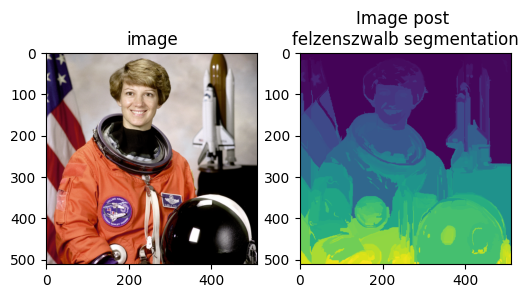

In [ ]:
segments_fz = felzenszwalb(img, scale=200)
segments_fz.shape
f, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(img)
ax[0].set_title("image")
ax[1].imshow(segments_fz)
ax[1].set_title("Image post \nfelzenszwalb segmentation");

In [ ]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

In [ ]:
candidates = extract_candidates(img)

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


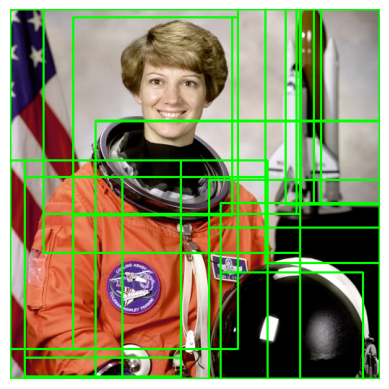

In [ ]:
def show_bboxes(img, bboxes):
    img = img.copy()
    for bb in bboxes:
        x, y, w, h = bb
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_bboxes(img, candidates)

### Датасет

Загрузим датасет OpenImages Bus Trucks - https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks

Этот датасет является подмножеством датасета Google Open Images v6, включающим только автобусы и грузовики.

Для загрузки датасета нам понадобится аккаунт Kaggle и API токен.

In [ ]:
files.upload() # upload kaggle.json file which you can get
# by clicking on Create New API token in your personal account
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks
!unzip -qq open-images-bus-trucks.zip

KeyboardInterrupt: 

In [ ]:
IMAGE_ROOT = 'images/images'
DF_RAW = pd.read_csv('df.csv')
print(DF_RAW.head())

            ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.34

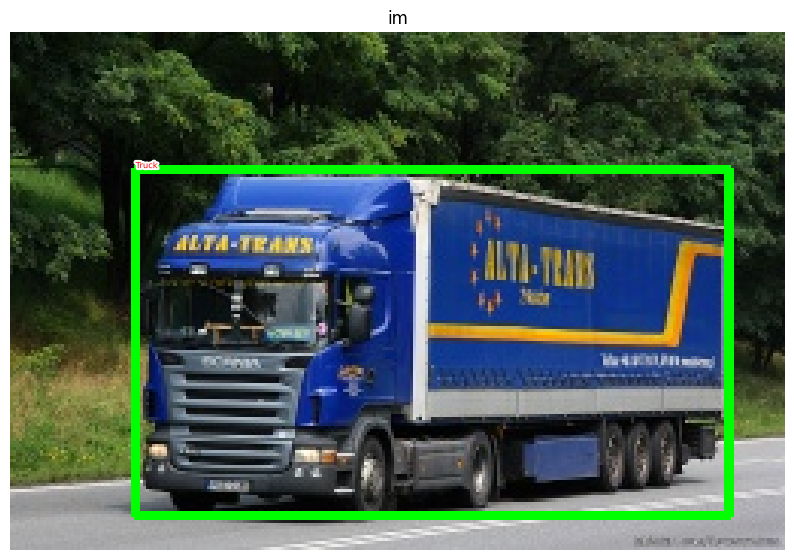

In [ ]:
class OpenImages(torch.utils.data.Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10)  # torch_snippets

In [ ]:
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [ ]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3

In [ ]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

In [ ]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds

In [ ]:
class RCNNDataset(torch.utils.data.Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

In [ ]:
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=2,
                                           collate_fn=train_ds.collate_fn,
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=2,
                                          collate_fn=test_ds.collate_fn,
                                          drop_last=True)

### Модель

In [ ]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 64.3MB/s]


In [ ]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

### Обучение

In [ ]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on: {device}")

model = RCNN().to(device)
criterion = model.calc_loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
n_epochs = 1
log = Report(n_epochs)  # torch_snippets

for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, model,
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss,
                   trn_regr_loss=regr_loss,
                   trn_acc=accs.mean(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs,
                                                model, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,
                val_regr_loss=regr_loss,
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

Training on: cpu


<ipython-input-19-44487e217ba6>:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  deltas = torch.Tensor(deltas).float().to(device)


EPOCH: 0.164  trn_loss: 2.479  trn_loc_loss: 0.208  trn_regr_loss: 0.227  trn_acc: 0.952  (2180.90s - 11081.33s remaining)

KeyboardInterrupt: 

### Тестирование

In [ ]:
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        model.eval()
        probs, deltas = model(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = torchvision.ops.nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

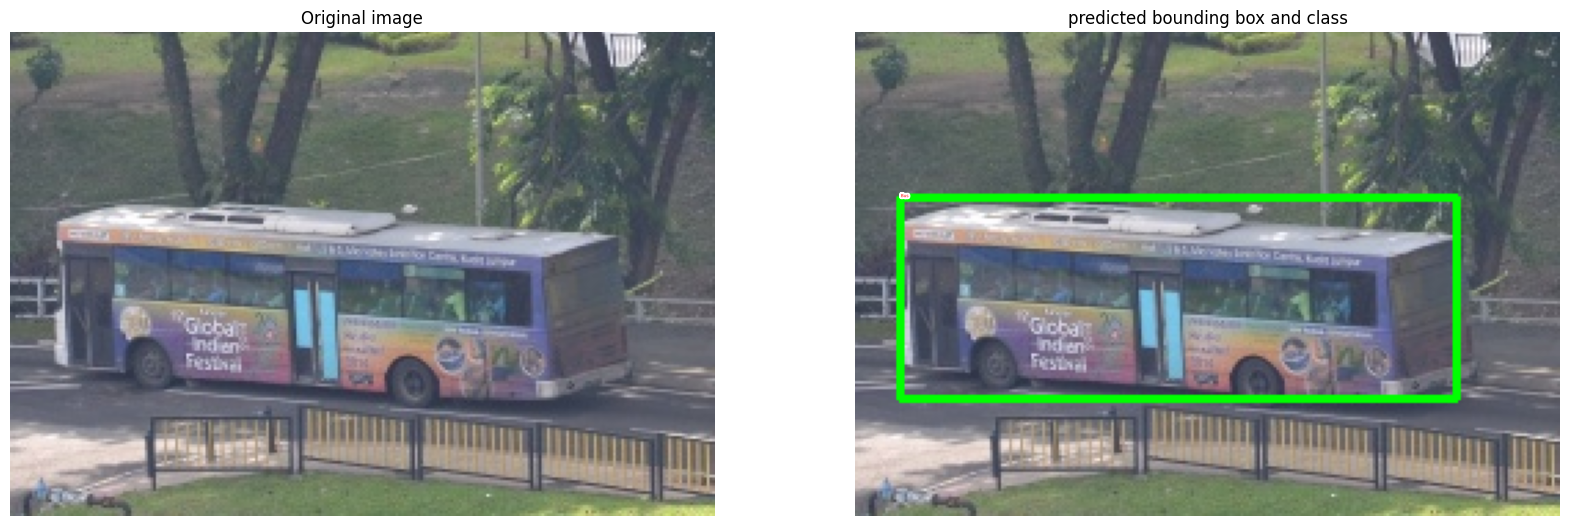

((16, 60, 218, 133), 'Bus', 0.9644924)

In [ ]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[7]
test_predictions(fpath)

## Region Proposal Network

1. **Общая сверточная база**  
   - Использует те же глубокие свёрточные слои, что и основная детектирующая сеть (например, в Faster R-CNN).

2. **Sliding window + Anchor boxes**  
   - По выходу свёрточного слоя движется «окно» фиксированного размера.
   - В каждой точке генерируется набор «якорей» (anchors) разных масштабов и соотношений сторон.

3. **Два «головных» слоя**  
   - **Классификатор объект-фон**: для каждого анкера предсказывает вероятность, что в нём есть объект.  
   - **Регрессор координат**: для анкер-прямоугольников выдаёт смещения (dx, dy, dw, dh) для уточнения границ.

4. **Отбор и фильтрация**  
   - Отбираются анкеры с высокой «objectness» score.  
   - Применяется Non-Maximum Suppression (NMS) для удаления сильно перекрывающихся предложений.

5. **End-to-end обучение**  
   - RPN обучается одновременно с детектором: общие свёрточные веса оптимизируются под обе задачи.
   - Благодаря этому RPN быстро генерирует качественные Region Proposals «на лету», без внешних алгоритмов (Selective Search).

**Итог:** RPN заменяет медленный классический генератор предложений, обеспечивая высокую скорость и эффективность в двухэтапных детекторах.  


#### Вопрос 1

_(оценивается)_

**Как работает Non-Maximum Suppression (NMS) и почему он важен?**

Ответ:

## One-stage: You Only Look Once


https://arxiv.org/abs/1506.02640

> Redmon, Joseph, et al. "You only look once: Unified, real-time object detection." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

**One-stage детекторы — основная идея:**

- Единый проход сети: детекция формулируется как прямая регрессия от пикселей изображения к координатам рамок + классам. Никакого отдельного поиска "кандидатов" (region proposals) — вся работа выполняется одной CNN.

- Плотный вывод: сеть сканирует изображение свёрточными слоями; на каждой позиции её выхода (обычно это ячейка сетки) одновременно предсказывает несколько ограничивающих рамок (anchor / bounding box) и вероятности классов.

- Скорость > точность: отказ от второго этапа резко ускоряет инференс (десятки FPS), зато рамки локализуются чуть грубее. Современные улучшения свели этот разрыв почти к нулю.


### Самостоятельная работа

_(вопросы и упражнения далее будут оцениваться)_

#### Вопрос 2

**В YOLOv1 изображение 448 × 448 делят на сетку 7 × 7. Сколько чисел предсказывает сеть для каждой ячейки при B = 2 боксах и C = 20 классах, и что это за числа?**

Ответ:

В YOLOv1 изображение делится на сетку размером $S \times S = 7 \times 7$, и для каждой ячейки сеть предсказывает:

Формула количества выходных значений на одну ячейку:
$$
B \times 5 + C
$$

где:
- $B = 2$ — количество предсказываемых границ (bounding boxes),
- каждая граница включает 5 чисел:
  $$
  (x, y, w, h, \text{confidence})
  $$
  - $x, y$ — координаты центра бокса в пределах ячейки (нормализованные от 0 до 1),
  - $w, h$ — ширина и высота бокса (нормализованные относительно изображения),
  - $\text{confidence}$ — вероятность, что в боксе есть объект и насколько хорошо он предсказан (IoU).
- $C = 20$ — количество классов, для которых сеть предсказывает априорные вероятности (одно распределение на ячейку, общее для всех боксов).

Подсчёт:
$$
2 \times 5 + 20 = 10 + 20 = 30
$$

### Итого:
Сеть предсказывает 30 чисел на каждую ячейку, из них:
- $2 \times (x, y, w, h, \text{confidence}) = 10$ чисел — для 2 предсказанных боксов,
- $20$ чисел — априорные вероятности классов.

Общее количество выходных значений по всему изображению:
$$
7 \times 7 \times 30 = 1470
$$


#### Вопрос 3

**Что такое objectness score и как он используется?**

Ответ:

### Что такое **objectness score** и как он используется в YOLOv1?

Objectness score — это значение, предсказываемое для каждого bounding box (бокса), которое отражает уверенность модели в том, что в боксе действительно находится объект (неклассифицированный). В YOLOv1 это часть выходного вектора каждого бокса:

$$
(x, y, w, h, \text{confidence})
$$

Где:
- $(x, y)$ — координаты центра бокса (в пределах ячейки),
- $(w, h)$ — ширина и высота бокса,
- confidence — это и есть objectness score, и он равен:
  $$
  \text{confidence} = P(\text{object}) \times \text{IoU}_{\text{pred, truth}}
  $$

где:
- $P(\text{object})$ — вероятность того, что в ячейке есть объект,
- $\text{IoU}_{\text{pred, truth}}$ — пересечение с истинным боксом (Intersection over Union).

### Как используется:
1. **Во время инференса**:
   - confidence score умножается на предсказанные вероятности классов:
     $$
     P(\text{class}_i | \text{object}) \times \text{confidence} = P(\text{class}_i) \times \text{IoU}
     $$
   - Таким образом, сеть предсказывает скор для каждой пары (бокс, класс).

2. **Во время обучения**:
   - loss-функция включает компоненту для предсказания objectness:
     - если объект есть, наказываются ошибки в предсказании $\text{IoU}$,
     - если объекта нет, сеть должна предсказывать $\text{confidence} \approx 0$.

#### Вопрос 4

**В чём назначение focal loss в RetinaNet и какую проблему YOLO решает по-другому?**

**Focal Loss** — модификация стандартного cross-entropy loss, предназначенная для:
- подавления вклада легко классифицируемых примеров (фон);
- фокусировки на сложных примерах (например, мелкие объекты).

Формула:
$$
\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log(p_t)
$$

где:
- $p_t$ — вероятность правильного класса;
- $\alpha_t$ — весовой коэффициент (для балансировки классов);
- $\gamma$ — фокусирующий параметр (обычно 2): чем выше $\gamma$, тем меньше вклад "лёгких" примеров.

### Какая проблема решается:
- В обычном классификационном loss большая часть градиента формируется за счёт огромного количества легко классифицируемых фонов;
- Это мешает модели хорошо обучаться на редких и сложных положительных примерах.

### Как YOLO решает эту проблему иначе

YOLO не использует anchor-based dense prediction, а делит изображение на фиксированную сетку $S \times S$:
- Каждая ячейка предсказывает ограниченное количество боксов (в YOLOv1 — $B=2$);
- Модель не "перебрасывается" миллионами негативных якорей — она изначально ограничивает число возможных предсказаний.


#### Упражнение

1. Выберите любую модель детекции из фреймворка Ultralytics https://docs.ultralytics.com/
2. Дообучите эту модель на любом публично доступном датасете с Hugging Face (для удобства выбирайте небольшие датасеты, например https://huggingface.co/datasets/keremberke/csgo-object-detection)

Далее вы должны представить набор ячеек, которые при запуске выполняют все необходимые операции end-to-end:
1. Установка зависимостей
2. Загрузка моделей
3. Загрузка данных
4. Обучение
5. Тестирование
6. Визуализация результатов (несколько изображений)

In [1]:
!pip install -U datasets

In [2]:
from datasets import load_dataset

dataset = load_dataset("Francesco/halo-infinite-angel-videogame")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.59k [00:00<?, ?B/s]

(…)-00000-of-00001-0d6632d599c29801.parquet:   0%|          | 0.00/16.5M [00:00<?, ?B/s]

(…)-00000-of-00001-c6b77a557eeedd52.parquet:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

(…)-00000-of-00001-866d29d8989ea915.parquet:   0%|          | 0.00/4.91M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [6]:
import os
from PIL import Image
from datasets import load_dataset

# Загрузка датасета
dataset = load_dataset("Francesco/halo-infinite-angel-videogame")

# Классы
classes = dataset['train'].features['objects'].feature['category'].names  # ['enemy']
class2id = {name: i for i, name in enumerate(classes)}  # {'enemy': 0}

# Создаём папки
for split in ['train', 'validation', 'test']:
    os.makedirs(f'halo/images/{split}', exist_ok=True)
    os.makedirs(f'halo/labels/{split}', exist_ok=True)

# Конвертация bbox в YOLO формат
def coco_to_yolo(bbox, w, h):
    x, y, bw, bh = bbox
    x_c = (x + bw / 2) / w
    y_c = (y + bh / 2) / h
    bw /= w
    bh /= h
    return x_c, y_c, bw, bh

# Сохраняем изображения и разметку
for split in ['train', 'validation', 'test']:
    for i, sample in enumerate(dataset[split]):
        img = sample['image']
        image_id = f"{i:04d}.jpg"
        img_path = f"halo/images/{split}/{image_id}"
        label_path = f"halo/labels/{split}/{image_id.replace('.jpg', '.txt')}"

        img.save(img_path)
        w, h = img.size

        valid_ids = [1, 2, 3, 4]

        with open(label_path, 'w') as f:
            for bbox, class_id in zip(sample['objects']['bbox'], sample['objects']['category']):
                if class_id in valid_ids:
                    x_c, y_c, bw, bh = coco_to_yolo(bbox, w, h)
                    f.write(f"{class_id - 1} {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}\n")



In [9]:
%%writefile halo.yaml
path: halo
train: images/train
val: images/validation

nc: 4
names: ["enemy", "enemy-head", "friendly", "friendly-head"]


Overwriting halo.yaml


In [11]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(data="halo.yaml", epochs=10, imgsz=640, batch=8)


Ultralytics 8.3.139 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=halo.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fals

train: Scanning /content/halo/labels/train... 462 images, 87 backgrounds, 0 corrupt: 100%|██████████| 462/462 [00:00<00:00, 2649.10it/s]

train: New cache created: /content/halo/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 737.3±346.2 MB/s, size: 37.8 KB)


val: Scanning /content/halo/labels/validation... 71 images, 12 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<00:00, 2115.30it/s]

val: New cache created: /content/halo/labels/validation.cache


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.09G      1.427      3.558      1.408         11        640: 100%|██████████| 58/58 [00:12<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

                   all         71        125      0.966       0.14      0.258      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.34G      1.276      2.475      1.247         13        640: 100%|██████████| 58/58 [00:09<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.44it/s]

                   all         71        125      0.685       0.42      0.477      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.35G      1.264      2.258      1.258         14        640: 100%|██████████| 58/58 [00:08<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]

                   all         71        125      0.774      0.512      0.609      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.37G      1.247      1.958      1.236         10        640: 100%|██████████| 58/58 [00:08<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.16it/s]

                   all         71        125      0.681      0.733      0.742      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.39G      1.212      1.793      1.196         12        640: 100%|██████████| 58/58 [00:09<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.39it/s]

                   all         71        125      0.733      0.657      0.745      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       1.4G      1.136      1.568      1.165         11        640: 100%|██████████| 58/58 [00:09<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]

                   all         71        125      0.776      0.726      0.778      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.42G      1.127      1.503      1.161          6        640: 100%|██████████| 58/58 [00:07<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.30it/s]

                   all         71        125       0.77      0.736      0.772      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.44G      1.046      1.344      1.119          8        640: 100%|██████████| 58/58 [00:09<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.67it/s]

                   all         71        125      0.808      0.808      0.861      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.46G     0.9969       1.26      1.099         13        640: 100%|██████████| 58/58 [00:09<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  8.59it/s]

                   all         71        125      0.713       0.78       0.79       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.47G     0.9869      1.186      1.082         12        640: 100%|██████████| 58/58 [00:07<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]

                   all         71        125      0.819      0.811      0.866      0.585



10 epochs completed in 0.029 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.139 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


                   all         71        125      0.821      0.813      0.866      0.584
                 enemy         50         56      0.935      0.929      0.976      0.805
            enemy-head         44         49      0.936      0.889      0.971      0.606
              friendly         12         12      0.587      0.833      0.823      0.666
         friendly-head          8          8      0.827        0.6      0.694      0.261
Speed: 0.5ms preprocess, 6.5ms inference, 0.0ms loss, 8.4ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dadec40db50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [12]:
%%writefile halo.yaml
path: halo
train: images/train
val: images/validation
test: images/test

nc: 4
names: ["enemy", "enemy-head", "friendly", "friendly-head"]


Overwriting halo.yaml


In [18]:
results = model.val(data="halo.yaml", split="test", save=False, verbose=False)

Ultralytics 8.3.139 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1205.7±544.9 MB/s, size: 31.2 KB)


val: Scanning /content/halo/labels/test.cache... 136 images, 30 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  7.54it/s]


                   all        136        259        0.8      0.881      0.841      0.581
Speed: 0.9ms preprocess, 6.0ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train46


In [19]:
print("mAP@0.5:", results.box.map50)
print("mAP@0.5:0.95:", results.box.map)

mAP@0.5: 0.8405052945939107
mAP@0.5:0.95: 0.5808781006520192



image 1/1 /content/halo/images/test/0000.jpg: 640x640 1 enemy, 1 enemy-head, 1 friendly, 1 friendly-head, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


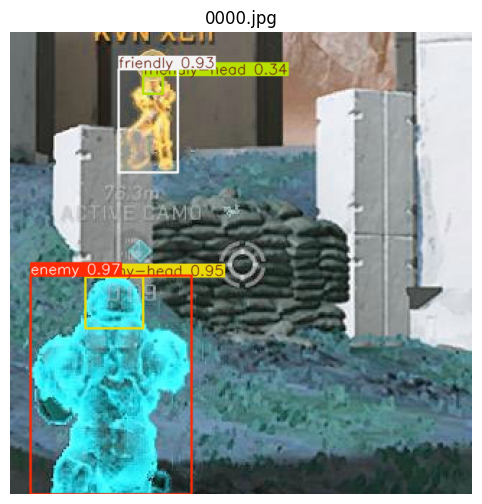


image 1/1 /content/halo/images/test/0001.jpg: 640x640 3 enemys, 12.4ms
Speed: 2.9ms preprocess, 12.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


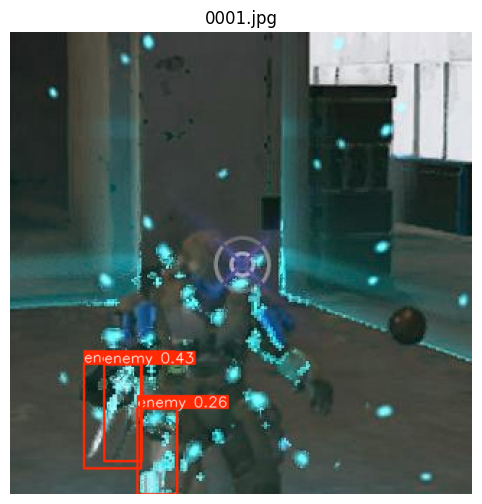


image 1/1 /content/halo/images/test/0002.jpg: 640x640 (no detections), 10.4ms
Speed: 2.7ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


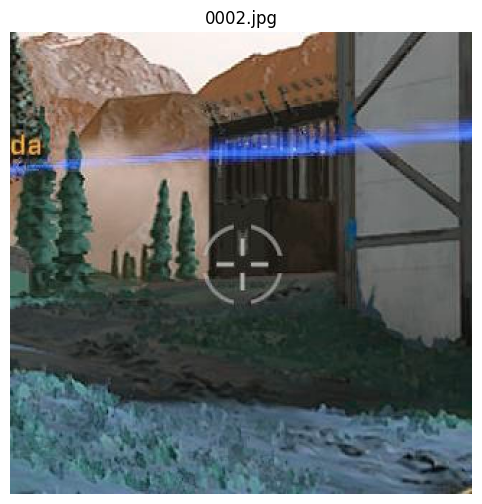


image 1/1 /content/halo/images/test/0003.jpg: 640x640 1 enemy, 1 enemy-head, 13.7ms
Speed: 3.2ms preprocess, 13.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


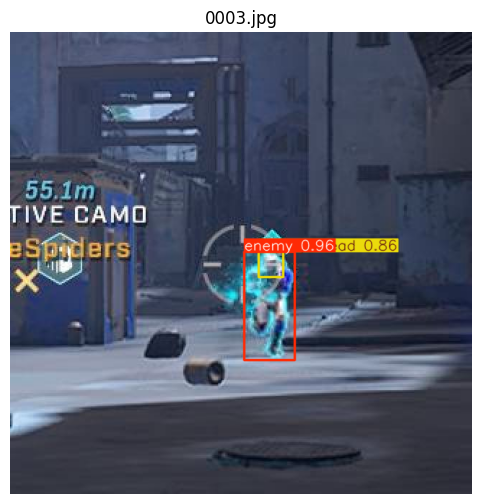


image 1/1 /content/halo/images/test/0004.jpg: 640x640 2 enemys, 1 enemy-head, 11.7ms
Speed: 2.8ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


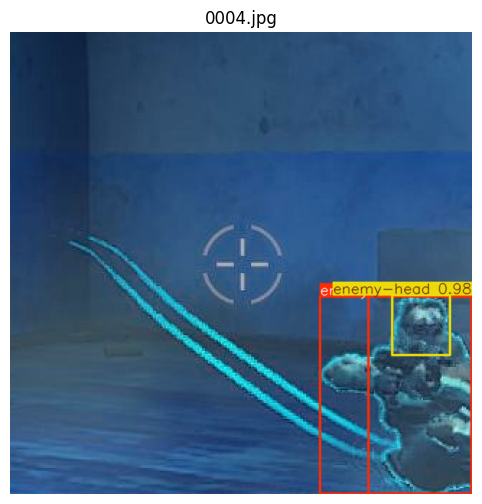

In [14]:
import glob
import matplotlib.pyplot as plt
import cv2

# Пути к изображениям
test_imgs = sorted(glob.glob("halo/images/test/*.jpg"))[:5]  # первые 5 изображений

for img_path in test_imgs:
    results = model(img_path)
    # results[0].plot() возвращает отрисованное изображение (NumPy array)
    pred_img = results[0].plot()

    plt.figure(figsize=(8, 6))
    plt.imshow(pred_img)
    plt.title(img_path.split("/")[-1])
    plt.axis("off")
    plt.show()
